Training with learning rate: 0.1
Epoch   500, Loss     2.1085
Epoch  1000, Loss     2.0907
Epoch  1500, Loss     2.0907
Epoch  2000, Loss     2.0907
Epoch  2500, Loss     2.0907
Epoch  3000, Loss     2.0907
Epoch  3500, Loss     2.0907
Epoch  4000, Loss     2.0907
Epoch  4500, Loss     2.0907
Epoch  5000, Loss     2.0907
Training with learning rate: 0.01
Epoch   500, Loss    26.2662
Epoch  1000, Loss    12.9497
Epoch  1500, Loss     6.9683
Epoch  2000, Loss     4.2816
Epoch  2500, Loss     3.0748
Epoch  3000, Loss     2.5327
Epoch  3500, Loss     2.2893
Epoch  4000, Loss     2.1799
Epoch  4500, Loss     2.1308
Epoch  5000, Loss     2.1087
Training with learning rate: 0.001
Epoch   500, Loss    58.8222
Epoch  1000, Loss    48.3482
Epoch  1500, Loss    44.3968
Epoch  2000, Loss    41.1184
Epoch  2500, Loss    38.1160
Epoch  3000, Loss    35.3459
Epoch  3500, Loss    32.7889
Epoch  4000, Loss    30.4286
Epoch  4500, Loss    28.2497
Epoch  5000, Loss    26.2383
Training with learning rate:

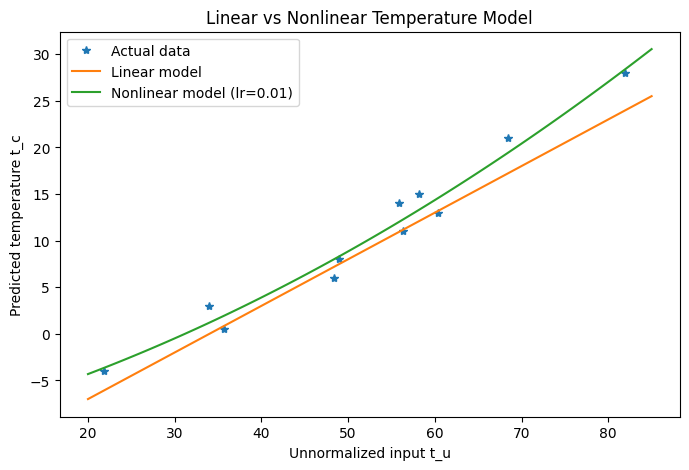

In [86]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Example Data
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

# Normalize input
t_un = t_u/100

# Nonlinear Model
def model(t_u, w2, w1, b):
    return w2 * t_u**2 + w1 * t_u + b

# Loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

# Training loop
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch:5d}, Loss {loss.item():10.4f}")

    return params

# Run trials for four learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    # initialize parameters similar to lecture
    params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
    optimizer = optim.SGD([params], lr=lr)

    trained_params = training_loop(5000, optimizer, params, t_un, t_c)
    results[lr] = trained_params.detach()

# Compare models
best_lr = 0.01

w2, w1, b = results[best_lr]
print(f"\nBest model parameters: w2={w2:.6f}, w1={w1:.6f}, b={b:.6f}")

# Plot nonlinear fit vs linear baseline
def linear_model(t_u, w, b):
    return w * t_u + b

# Suppose the baseline linear model params from lecture:
w_lin, b_lin = torch.tensor([0.5]), torch.tensor([-17.0])

t_range = torch.linspace(20.0, 85.0, steps=100)
plt.figure(figsize=(8,5))
plt.plot(t_u, t_c, '*', label='Actual data')
plt.plot(t_range, linear_model(1 * t_range, w_lin, b_lin), '-', label='Linear model')
plt.plot(t_range, model(0.01 * t_range, w2, w1, b), '-', label=f'Nonlinear model (lr={best_lr})')
plt.xlabel("Unnormalized input t_u")
plt.ylabel("Predicted temperature t_c")
plt.legend()
plt.title("Linear vs Nonlinear Temperature Model")
plt.show()


In [87]:
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/b4cf4ac187d647a443dc011c4ee85fbb42e26096/Dataset/Housing.csv'
housing_data = pd.read_csv(url)

# Define a data mapping
def data_map(series):
    mapping = {
        'yes': 1, 'no': 0,
        'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0
    }
    return series.map(mapping)

# Columns to encode
data_nan_columns = [
    'mainroad', 'guestroom', 'basement',
    'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus'
]

housing_data[data_nan_columns] = housing_data[data_nan_columns].apply(data_map)

# Scale all relevant numeric
scaler = MinMaxScaler()
data_cols = [
    'price', 'area', 'bedrooms', 'bathrooms', 'stories',
    'mainroad', 'guestroom', 'basement', 'hotwaterheating',
    'airconditioning', 'parking', 'prefarea', 'furnishingstatus'
]
housing_data[data_cols] = scaler.fit_transform(housing_data[data_cols])

df_train, df_test = train_test_split(housing_data, train_size=0.8, random_state=100)

# Separate inputs/outputs
y_train = df_train.pop('price').values.reshape(-1, 1)
X_train = df_train[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']].values
y_test  = df_test.pop('price').values.reshape(-1, 1)
X_test  = df_test[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']].values

X_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
X_test  = np.column_stack((np.ones(X_test.shape[0]), X_test))

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_test)}")

def model(X, weights):
    return X @ weights  # bias included as first column of ones

def loss_fn(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean()

def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    return (1 - ss_res / ss_tot).item()


# Training loop
def training_loop(X_train, y_train, X_val, y_val, lr, n_epochs=5000):
    weights = torch.zeros((X_train.shape[1], 1), requires_grad=True)
    optimizer = optim.SGD([weights], lr=lr)
    history = []

    for epoch in range(1, n_epochs + 1):
        y_pred = model(X_train, weights)
        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_pred = model(X_val, weights)
            val_loss = loss_fn(val_pred, y_val)
            val_r2 = r2_score(y_val, val_pred)

        if epoch % 500 == 0:
            print(f"LR={lr:<7} Epoch={epoch:5d} | "
                  f"Train Loss={loss.item():.6f} | "
                  f"Val Loss={val_loss.item():.6f} | "
                  f"Val Acc={val_r2*100:6.2f}%")
            history.append((epoch, loss.item(), val_loss.item(), val_r2))

    return weights.detach(), history

# Train for multiple learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    w, hist = training_loop(X_train, y_train, X_test, y_test, lr)
    results[lr] = (w, hist)

# Evaluate best model
best_lr, best_acc = None, -1
for lr, (_, hist) in results.items():
    final_acc = hist[-1][3]
    print(f"Final Val Accuracy (LR={lr}) = {final_acc*100:.2f}%")
    if final_acc > best_acc:
        best_acc = final_acc
        best_lr = lr

print(f"\nBest learning rate: {best_lr} (Val Accuracy={best_acc*100:.2f}%)")

best_w, _ = results[best_lr]

# Display learned parameters
print("\nLearned weights and bias:")
for i, col in enumerate(['Bias','area','bedrooms','bathrooms','stories','parking']):
    print(f"{col:<12}: {best_w[i].item():.6f}")


Training samples: 436, Validation samples: 109

Training with learning rate: 0.1
LR=0.1     Epoch=  500 | Train Loss=0.011486 | Val Loss=0.011659 | Val Acc= 55.93%
LR=0.1     Epoch= 1000 | Train Loss=0.011412 | Val Loss=0.011913 | Val Acc= 54.97%
LR=0.1     Epoch= 1500 | Train Loss=0.011410 | Val Loss=0.011957 | Val Acc= 54.81%
LR=0.1     Epoch= 2000 | Train Loss=0.011410 | Val Loss=0.011965 | Val Acc= 54.77%
LR=0.1     Epoch= 2500 | Train Loss=0.011410 | Val Loss=0.011967 | Val Acc= 54.77%
LR=0.1     Epoch= 3000 | Train Loss=0.011410 | Val Loss=0.011968 | Val Acc= 54.77%
LR=0.1     Epoch= 3500 | Train Loss=0.011410 | Val Loss=0.011968 | Val Acc= 54.77%
LR=0.1     Epoch= 4000 | Train Loss=0.011410 | Val Loss=0.011968 | Val Acc= 54.77%
LR=0.1     Epoch= 4500 | Train Loss=0.011410 | Val Loss=0.011968 | Val Acc= 54.77%
LR=0.1     Epoch= 5000 | Train Loss=0.011410 | Val Loss=0.011968 | Val Acc= 54.77%

Training with learning rate: 0.01
LR=0.01    Epoch=  500 | Train Loss=0.015244 | Val Los

In [88]:

housing_data = pd.read_csv(url)

def data_map(series):
    mapping = {
        'yes': 1, 'no': 0,
        'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0
    }
    return series.map(mapping)

data_nan_columns = [
    'mainroad', 'guestroom', 'basement',
    'hotwaterheating', 'airconditioning',
    'prefarea', 'furnishingstatus'
]

housing_data[data_nan_columns] = housing_data[data_nan_columns].apply(data_map)

# Scale all columns
scaler = MinMaxScaler()
data_cols = [
    'price', 'area', 'bedrooms', 'bathrooms', 'stories',
    'mainroad', 'guestroom', 'basement', 'hotwaterheating',
    'airconditioning', 'parking', 'prefarea', 'furnishingstatus'
]
housing_data[data_cols] = scaler.fit_transform(housing_data[data_cols])

df_train, df_test = train_test_split(housing_data, train_size=0.8, random_state=100)

X_train = df_train[['area','bedrooms','bathrooms','stories','parking']].values
y_train = df_train['price'].values.reshape(-1, 1)
X_val   = df_test[['area','bedrooms','bathrooms','stories','parking']].values
y_val   = df_test['price'].values.reshape(-1, 1)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.float32)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

model = nn.Sequential(
    nn.Linear(5, 8),     # input: 5 features  hidden: 8
    nn.ReLU(),
    nn.Linear(8, 1)      # hidden output (price)
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


n_epochs = 200
start_time = time.time()

for epoch in range(1, n_epochs + 1):
    # Forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation accuracy R2
    with torch.no_grad():
        val_pred = model(X_val)
        ss_res = ((y_val - val_pred) ** 2).sum()
        ss_tot = ((y_val - y_val.mean()) ** 2).sum()
        val_r2 = (1 - ss_res / ss_tot).item()

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{n_epochs} | "
              f"Train Loss={loss.item():.6f} | "
              f"Val Acc={val_r2*100:6.2f}%")

end_time = time.time()
training_time = end_time - start_time


with torch.no_grad():
    final_pred = model(X_val)
    final_loss = criterion(final_pred, y_val).item()
    ss_res = ((y_val - final_pred) ** 2).sum()
    ss_tot = ((y_val - y_val.mean()) ** 2).sum()
    final_r2 = (1 - ss_res / ss_tot).item()

print("\nTraining complete!")
print(f"Training time: {training_time:.2f} seconds")
print(f"Final Training Loss: {loss.item():.6f}")
print(f"Validation Accuracy (R2): {final_r2*100:.2f}%")


Training samples: 436, Validation samples: 109
Epoch   1/200 | Train Loss=0.065663 | Val Acc=-103.32%
Epoch  20/200 | Train Loss=0.021295 | Val Acc= 22.31%
Epoch  40/200 | Train Loss=0.016385 | Val Acc= 40.80%
Epoch  60/200 | Train Loss=0.013711 | Val Acc= 48.74%
Epoch  80/200 | Train Loss=0.012590 | Val Acc= 51.14%
Epoch 100/200 | Train Loss=0.011891 | Val Acc= 52.70%
Epoch 120/200 | Train Loss=0.011536 | Val Acc= 53.60%
Epoch 140/200 | Train Loss=0.011386 | Val Acc= 54.37%
Epoch 160/200 | Train Loss=0.011335 | Val Acc= 54.97%
Epoch 180/200 | Train Loss=0.011315 | Val Acc= 55.33%
Epoch 200/200 | Train Loss=0.011291 | Val Acc= 55.54%

Training complete!
Training time: 0.15 seconds
Final Training Loss: 0.011291
Validation Accuracy (R2): 55.54%


In [89]:


def data_map(series):
    mapping = {
        'yes': 1, 'no': 0,
        'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0
    }
    return series.map(mapping)

data_nan_columns = [
    'mainroad', 'guestroom', 'basement',
    'hotwaterheating', 'airconditioning',
    'prefarea', 'furnishingstatus'
]
housing_data[data_nan_columns] = housing_data[data_nan_columns].apply(data_map)

# Scale all numeric + categorical columns
scaler = MinMaxScaler()
data_cols = [
    'price', 'area', 'bedrooms', 'bathrooms', 'stories',
    'mainroad', 'guestroom', 'basement', 'hotwaterheating',
    'airconditioning', 'parking', 'prefarea', 'furnishingstatus'
]
housing_data[data_cols] = scaler.fit_transform(housing_data[data_cols])

df_train, df_test = train_test_split(housing_data, train_size=0.8, random_state=100)
X_train = df_train[['area','bedrooms','bathrooms','stories','parking']].values
y_train = df_train['price'].values.reshape(-1, 1)
X_val   = df_test[['area','bedrooms','bathrooms','stories','parking']].values
y_val   = df_test['price'].values.reshape(-1, 1)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.float32)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

model = nn.Sequential(
    nn.Linear(5, 16),    # first hidden layer (more neurons)
    nn.ReLU(),
    nn.Linear(16, 8),    # second hidden layer
    nn.ReLU(),
    nn.Linear(8, 4),     # third hidden layer
    nn.ReLU(),
    nn.Linear(4, 1)      # output layer (regression)
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 200
start_time = time.time()

for epoch in range(1, n_epochs + 1):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        val_pred = model(X_val)
        ss_res = ((y_val - val_pred) ** 2).sum()
        ss_tot = ((y_val - y_val.mean()) ** 2).sum()
        val_r2 = (1 - ss_res / ss_tot).item()

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{n_epochs} | "
              f"Train Loss={loss.item():.6f} | Val Acc={val_r2*100:6.2f}%")

end_time = time.time()
training_time = end_time - start_time

with torch.no_grad():
    final_pred = model(X_val)
    final_loss = criterion(final_pred, y_val).item()
    ss_res = ((y_val - final_pred) ** 2).sum()
    ss_tot = ((y_val - y_val.mean()) ** 2).sum()
    final_r2 = (1 - ss_res / ss_tot).item()

print("\nTraining complete!")
print(f"Training time: {training_time:.2f} seconds")
print(f"Final Training Loss: {loss.item():.6f}")
print(f"Validation Accuracy (R2): {final_r2*100:.2f}%")


Training samples: 436, Validation samples: 109
Epoch   1/200 | Train Loss=0.117031 | Val Acc=-290.78%
Epoch  20/200 | Train Loss=0.029039 | Val Acc=-10.43%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Epoch  40/200 | Train Loss=0.017890 | Val Acc= 34.03%
Epoch  60/200 | Train Loss=0.014312 | Val Acc= 48.45%
Epoch  80/200 | Train Loss=0.012265 | Val Acc= 55.06%
Epoch 100/200 | Train Loss=0.011782 | Val Acc= 54.83%
Epoch 120/200 | Train Loss=0.011531 | Val Acc= 54.72%
Epoch 140/200 | Train Loss=0.011449 | Val Acc= 54.79%
Epoch 160/200 | Train Loss=0.011427 | Val Acc= 54.87%
Epoch 180/200 | Train Loss=0.011419 | Val Acc= 54.91%
Epoch 200/200 | Train Loss=0.011413 | Val Acc= 54.92%

Training complete!
Training time: 0.23 seconds
Final Training Loss: 0.011413
Validation Accuracy (R2): 54.92%
